### Topic Modeling

Reference: https://medium.com/airy-science/gain-insights-from-customers-review-using-topic-modelling-2ae632be202b

In [1]:
import pandas as pd
import warnings
import json
import datetime
import umap.umap_ as umap
import matplotlib.pyplot as plt
import seaborn as sns
import lda
import numpy as np
import pyLDAvis

from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
from sklearn.feature_extraction.text import CountVectorizer 

plt.style.use('ggplot')
warnings.filterwarnings(action="ignore")

### A. Import datasets

---

In [2]:
gcash_good = pd.read_csv('../../Data/Preprocessed/Mico/App Store/gcash_good.csv')
gcash_bad = pd.read_csv('../../Data/Preprocessed/Mico/App Store/gcash_bad.csv')
paymaya_good = pd.read_csv('../../Data/Preprocessed/Mico/App Store/paymaya_good.csv')
paymaya_bad = pd.read_csv('../../Data/Preprocessed/Mico/App Store/paymaya_bad.csv')

In [3]:
def rating_plot(df1, df2, gb):
    df = df1['rating'].value_counts().rename(f'GCash {gb} Reviews').to_frame()\
         .join(df2['rating'].value_counts().rename(f'PayMaya {gb} Reviews').to_frame())
    df.plot(kind='bar')
    plt.xlabel("Rating")
    plt.ylabel("Count")
    plt.title(f"{gb} Reviews (January 2020 - May 2021)")
    print(f"GCash {gb} Reviews:\n{df1['rating'].value_counts()}\n")
    print(f"PayMaya {gb} Reviews:\n{df2['rating'].value_counts()}\n")

GCash Good Reviews:
5    182
4    129
Name: rating, dtype: int64

PayMaya Good Reviews:
5    434
4     42
Name: rating, dtype: int64



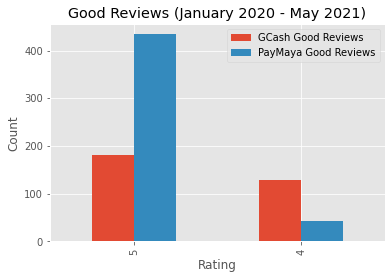

In [4]:
rating_plot(gcash_good, paymaya_good, 'Good')

GCash Bad Reviews:
1    1458
2     373
3     360
Name: rating, dtype: int64

PayMaya Bad Reviews:
1    580
2     97
3     67
Name: rating, dtype: int64



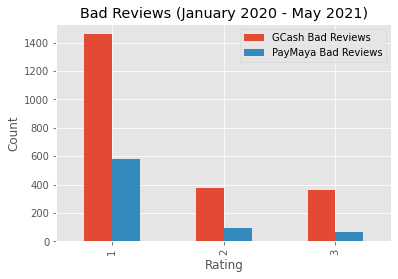

In [5]:
rating_plot(gcash_bad, paymaya_bad, 'Bad')

### B. Dimension Reduction

We reduce the dimensions of our features so that we can visualize our dataset.

---

In [6]:
def reduce(df):
    vectorizer = TfidfVectorizer(min_df=10, max_features=100000, ngram_range=(1,2))
    vz = vectorizer.fit_transform(df['title_review_tokenized'])
    
    svd_model = TruncatedSVD(n_components=50)
    svd_tfidf = svd_model.fit_transform(vz)
    
    umap_model = umap.UMAP(n_components=2)
    umap_tfidf = umap_model.fit_transform(svd_tfidf)
    
    return umap_tfidf

In [7]:
gcash_good_umap=reduce(gcash_good)
gcash_bad_umap=reduce(gcash_bad)
paymaya_good_umap=reduce(paymaya_good)
paymaya_bad_umap=reduce(paymaya_bad)

### C. Clustering

Cluster the data to determine optimal division of groups or topics.

---

In [8]:
def cluster(umap):
    dbscan = DBSCAN(eps=1, min_samples = 15)
    dbscan_model = dbscan.fit(umap)
    y_dbscan = dbscan.labels_
    plt.scatter(umap[:, 0], umap[:, 1], c=y_dbscan, s=50)
    return dbscan_model

DBSCAN(eps=1, min_samples=15)

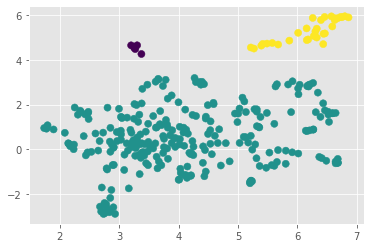

In [9]:
cluster(gcash_good_umap)

DBSCAN(eps=1, min_samples=15)

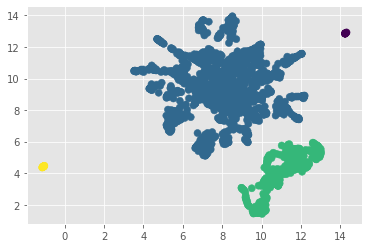

In [10]:
cluster(gcash_bad_umap)

DBSCAN(eps=1, min_samples=15)

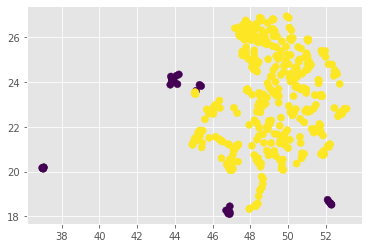

In [11]:
cluster(paymaya_good_umap)

DBSCAN(eps=1, min_samples=15)

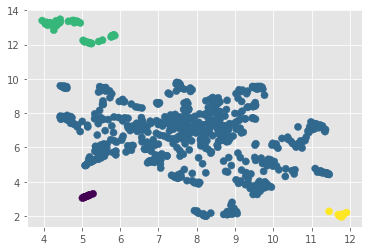

In [12]:
cluster(paymaya_bad_umap)

### D. Topic Modeling

---

First, we create the document term matrix per dataset.

In [13]:
def vectorize(df):
    vectorizer = CountVectorizer(min_df = 5, # Minimum required occurences of a word
                                max_features=10000, # Maximum number of unique words
                                ngram_range=(1,2)) # Sequence of N words
    
    return vectorizer, vectorizer.fit_transform(df['title_review_tokenized'])

In [14]:
gcash_good_vect, X_gcash_good = vectorize(gcash_good)
gcash_bad_vect,X_gcash_bad = vectorize(gcash_bad)
paymaya_good_vect,X_paymaya_good = vectorize(paymaya_good)
paymaya_bad_vect, X_paymaya_bad = vectorize(paymaya_bad)

In [15]:
def lda_model(n_topics, X):
    lda_model = lda.LDA(n_topics = n_topics, # Number of topics
                        n_iter = 5000) # Number of learning iterations
    
    X_topics = lda_model.fit_transform(X) # X is document term matrix
    
    return lda_model

In [16]:
gcash_good_lda = lda_model(4, X_gcash_good)
gcash_bad_lda = lda_model(4, X_gcash_bad)
paymaya_good_lda = lda_model(4, X_paymaya_good)
paymaya_bad_lda = lda_model(4, X_paymaya_bad)

INFO:lda:n_documents: 311
INFO:lda:vocab_size: 223
INFO:lda:n_words: 3609
INFO:lda:n_topics: 4
INFO:lda:n_iter: 5000
INFO:lda:<0> log likelihood: -28397
INFO:lda:<10> log likelihood: -21273
INFO:lda:<20> log likelihood: -20903
INFO:lda:<30> log likelihood: -20749
INFO:lda:<40> log likelihood: -20616
INFO:lda:<50> log likelihood: -20574
INFO:lda:<60> log likelihood: -20472
INFO:lda:<70> log likelihood: -20487
INFO:lda:<80> log likelihood: -20422
INFO:lda:<90> log likelihood: -20387
INFO:lda:<100> log likelihood: -20309
INFO:lda:<110> log likelihood: -20347
INFO:lda:<120> log likelihood: -20382
INFO:lda:<130> log likelihood: -20216
INFO:lda:<140> log likelihood: -20271
INFO:lda:<150> log likelihood: -20219
INFO:lda:<160> log likelihood: -20156
INFO:lda:<170> log likelihood: -20235
INFO:lda:<180> log likelihood: -20105
INFO:lda:<190> log likelihood: -20112
INFO:lda:<200> log likelihood: -20139
INFO:lda:<210> log likelihood: -20164
INFO:lda:<220> log likelihood: -20102
INFO:lda:<230> log l

In [17]:
def print_topics(name, n_top_words, lda_model, vectorizer):
    print(f"{name} Reviews Topics:\n")
    topic_summaries = []
    topic_word = lda_model.topic_word_  # get the topic words
    vocab = vectorizer.get_feature_names()
    for i, topic_dist in enumerate(topic_word):
        topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
        topic_summaries.append(' '.join(topic_words))
        print('Topic {}: {}'.format(i, ' '.join(topic_words)))

In [18]:
print_topics("GCash Good",10, gcash_good_lda, gcash_good_vect)

GCash Good Reviews Topics:

Topic 0: update time use good transaction problem need service one make
Topic 1: id add hope option feature good would limit load available
Topic 2: pay bill use bank transfer easy pay bill money also like
Topic 3: account money send number cash help verify email use get


In [19]:
print_topics("GCash Bad",10, gcash_bad_lda, gcash_bad_vect)

GCash Bad Reviews Topics:

Topic 0: verify id account student verify account fully verification crash student id fully verify
Topic 1: account service try customer time still customer service email send get
Topic 2: update always cash pera paypal wala load kayo service pag
Topic 3: use money cash transaction pay load bank bill transfer fix


In [20]:
print_topics("PayMaya Good",10, paymaya_good_lda, paymaya_good_vect)

PayMaya Good Reviews Topics:

Topic 0: use load easy convenient transaction easy use love great fee fast
Topic 1: pay bill payment convenient use pay bill easy online need make
Topic 2: user application good great online transaction like feature really best
Topic 3: money account bank transfer use good service customer send time


In [21]:
print_topics("PayMaya Bad",10, paymaya_bad_lda, paymaya_bad_vect)

PayMaya Bad Reviews Topics:

Topic 0: service account customer money customer service use email try time still
Topic 1: error try load fix internet say connection log update account
Topic 2: upgrade account id upgrade account transfer bank update need even money
Topic 3: card use add money add money pay virtual credit bill virtual card


### Topic Visualization
To follow

--- 